In [2]:
import torch
from PIL import Image
import depth_pro

image_path = "C:\\Users\\monol\\Desktop\\food_image\\ข้าวไก่ย่าง\\1dccbfbf51e74114b2e4246c4ca4cbd2.webp"

# Load model and preprocessing transform
model, transform = depth_pro.create_model_and_transforms()

# Check if MPS is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to the device

model.eval()

# Load and preprocess an image
image, _, f_px = depth_pro.load_rgb(image_path)
image = transform(image).to(device)  # Move the image to the same device as the model

# Run inference
prediction = model.infer(image, f_px=f_px)
depth = prediction["depth"]  # Depth in [m]
print(depth)

focallength_px = prediction["focallength_px"]  # Focal length in pixels
print(focallength_px)


tensor([[0.6850, 0.6416, 0.6211,  ..., 0.5420, 0.5592, 0.6148],
        [0.6430, 0.6282, 0.6134,  ..., 0.5311, 0.5447, 0.5506],
        [0.6254, 0.6141, 0.6070,  ..., 0.5243, 0.5297, 0.5401],
        ...,
        [0.4319, 0.4311, 0.4307,  ..., 0.3979, 0.3983, 0.3980],
        [0.4311, 0.4306, 0.4288,  ..., 0.3975, 0.3983, 0.3982],
        [0.4400, 0.4294, 0.4286,  ..., 0.3961, 0.3983, 0.4111]])
tensor(1064.9619)


In [3]:

img = Image.open(image_path)
width_px, height_px = img.size
print(width_px, height_px)

1080 1080


focal length (px): tensor(1064.9619)


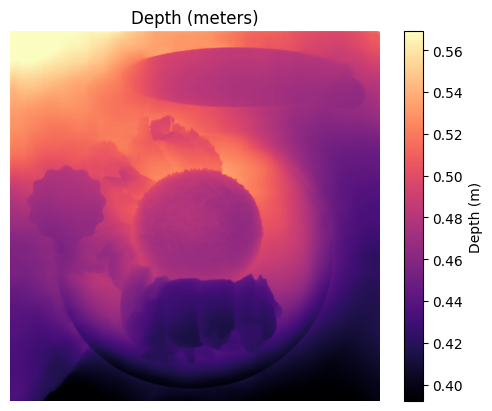

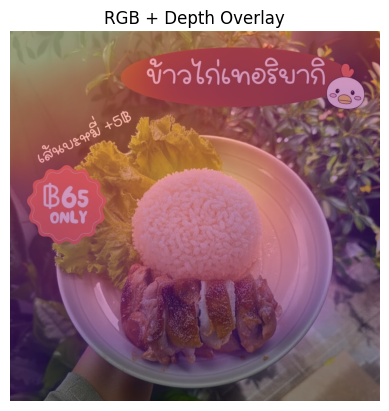

Depth at center (540,540): 0.478 m
ROI median depth: 0.476 m
Saved: depth_color.png, depth_mm_uint16.png


In [4]:
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

# --- (1) Run inference safely ---
with torch.no_grad():
    prediction = model.infer(image, f_px=f_px)

depth = prediction["depth"]            # H×W (meters) or 1×H×W; depends on build
if isinstance(depth, torch.Tensor):
    depth = depth.squeeze().cpu().numpy()  # -> H×W, float32

# Optional: focal length (pixels)
focallength_px = prediction.get("focallength_px", None)
print("focal length (px):", focallength_px)

# --- (2) Display the depth with a colorbar (meters) ---
plt.figure()
vmin = np.nanpercentile(depth, 1)
vmax = np.nanpercentile(depth, 99)
plt.imshow(depth, cmap="magma", vmin=vmin, vmax=vmax)
plt.colorbar(label="Depth (m)")
plt.title("Depth (meters)")
plt.axis("off")
plt.show()

# --- (3) Overlay depth colors on the original RGB image ---
rgb = Image.open(image_path).convert("RGB")
rgb_np = np.array(rgb)

# Normalize depth [0..1] just for coloring (visualization only)
d = depth.copy()
d[~np.isfinite(d)] = np.nan
dmin, dmax = np.nanpercentile(d, 1), np.nanpercentile(d, 99)
d = np.clip((d - dmin) / (dmax - dmin + 1e-8), 0, 1)

# Colorize
cmap = plt.get_cmap("magma")
depth_color = (cmap(d)[..., :3] * 255).astype(np.uint8)  # H×W×3

# Blend with RGB (alpha controls strength)
alpha = 0.5
overlay = (alpha * depth_color + (1 - alpha) * rgb_np).astype(np.uint8)

plt.figure()
plt.imshow(overlay)
plt.title("RGB + Depth Overlay")
plt.axis("off")
plt.show()

# --- (4) Read distance at a pixel or an ROI (meters) ---
H, W = depth.shape
u, v = W // 2, H // 2             # center pixel
dist_center = float(depth[v, u])
print(f"Depth at center ({u},{v}): {dist_center:.3f} m")

# ROI example: middle 20% of the image
ys = slice(int(H*0.4), int(H*0.6))
xs = slice(int(W*0.4), int(W*0.6))
roi_vals = depth[ys, xs]
roi_vals = roi_vals[np.isfinite(roi_vals)]
if roi_vals.size:
    print(f"ROI median depth: {np.median(roi_vals):.3f} m")

# --- (5) Save a pretty depth image and a 16-bit metric map ---
# (A) Pretty color PNG (for viewing)
Image.fromarray(depth_color).save("depth_color.png")

# (B) 16-bit grayscale encoding meters->millimeters (for later processing)
depth_mm = depth.copy()
depth_mm[~np.isfinite(depth_mm)] = 0
depth_mm = np.clip(depth_mm * 1000.0, 0, 65535).astype(np.uint16)
Image.fromarray(depth_mm).save("depth_mm_uint16.png")
print("Saved: depth_color.png, depth_mm_uint16.png")


In [2]:
import sys
print(sys.executable) 

/Library/Frameworks/Python.framework/Versions/3.14/bin/python3.14
